# Projet Data Analyst – Revenue Management Hôtelier  
## Optimisation du revenu net à partir de l’analyse des réservations

# 1. Introduction

## Contexte

Le secteur hôtelier fonctionne dans un environnement hautement concurrentiel où la gestion du revenu (Revenue Management) est essentielle pour assurer la rentabilité.

Les annulations de réservation représentent un risque majeur, impactant directement le taux d’occupation, le revenu généré et la planification tarifaire. Une mauvaise anticipation du comportement client peut entraîner une perte de revenu significative.

Dans ce contexte, l’analyse des données de réservation constitue un levier stratégique pour ajuster les prix, limiter le risque d’annulation et optimiser le revenu net.

## Problématique

Comment un hôtel peut-il analyser le comportement de réservation et le risque d’annulation afin d’optimiser sa stratégie tarifaire et maximiser son revenu net ?

## Objectifs de l’analyse

- Mesurer les KPI clés du Revenue Management (ADR, taux d’annulation, revenu net).
- Identifier les segments clients et canaux les plus rentables.
- Analyser les facteurs influençant le risque d’annulation.
- Formuler des recommandations concrètes pour améliorer la performance revenue.

# 2. Extraction & KPI via SQL

## 2.1 Présentation des données

Source : Hotel Booking Demand (Kaggle)

Le dataset contient environ 119 000 réservations provenant de deux hôtels :
- Resort Hotel
- City Hotel

Les données incluent :
- Informations tarifaires (ADR)
- Données temporelles
- Segmentation client
- Canal de distribution
- Indicateur d’annulation

Les données ont été importées dans une base MySQL afin de réaliser les extractions et calculs de KPI via SQL.

In [1]:
import pandas as pd
from urllib.parse import quote_plus
from sqlalchemy import create_engine

csv_path = r"C:\Users\solen\Desktop\FORMATION DATA ANALYST - Novembre 2025\MODULE 7 - Projet final\hotel_bookings.csv"

In [2]:
df = pd.read_csv(csv_path)

print("✅ CSV chargé")
print("Shape:", df.shape)
df.head()

✅ CSV chargé
Shape: (119390, 32)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
mysql_user = "solenn"
mysql_password = quote_plus("MDP") 
mysql_host = "localhost"
mysql_port = 3306
mysql_db = "hotel_rm"

engine = create_engine(
    f"mysql+pymysql://{mysql_user}:{mysql_password}@{mysql_host}:{mysql_port}/{mysql_db}"
)

print("✅ Engine SQLAlchemy prêt")

✅ Engine SQLAlchemy prêt


In [4]:
df.to_sql(
    "bookings",
    con=engine,
    if_exists="replace",
    index=False,
    chunksize=5000
)

print("✅ Import terminé dans MySQL : table = bookings")

✅ Import terminé dans MySQL : table = bookings


## Contrôle qualité rapide
On vérifie que la table est bien chargée et on observe les premières lignes.

In [5]:
check = pd.read_sql("SELECT COUNT(*) AS n FROM bookings;", con=engine)
check

,n
0,119390


In [6]:
pd.read_sql("SELECT * FROM bookings LIMIT 5;", con=engine)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,None,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,None,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,None,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,None,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,None,0,Transient,98.0,0,1,Check-Out,2015-07-03


## KPI globaux
- Nombre de réservations
- ADR moyen (Average Daily Rate : Prix moyen par chambre et par nuit)
- Taux d'annulation
- Revenu net estimé (sans annulation)

In [7]:
kpi_global = pd.read_sql("""
SELECT
  COUNT(*) AS bookings,
  ROUND(AVG(adr), 2) AS avg_adr,
  ROUND(AVG(is_canceled) * 100, 2) AS cancellation_rate_pct,
  ROUND(SUM(adr * (1 - is_canceled)), 2) AS revenue_net_est
FROM bookings;
""", con=engine)

kpi_global

,bookings,avg_adr,cancellation_rate_pct,revenue_net_est
0,119390,101.83,37.04,7515674.93


Ces indicateurs permettent d’obtenir une vision globale de la performance avant analyse approfondie.

# 3. Préparation des données

## 3.1 Analyse des valeurs manquantes

Objectif : identifier les colonnes contenant des valeurs manquantes et définir une stratégie de traitement adaptée.

Méthodologie :
- Calcul du nombre et du pourcentage de valeurs manquantes.
- Décision de suppression ou d’imputation selon l’impact métier.

In [8]:
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (df.isnull().sum() / len(df)) * 100

pd.DataFrame({
    "Missing Values": missing,
    "Percentage": missing_pct
}).sort_values(by="Percentage", ascending=False)

,Missing Values,Percentage
company,112593,94.306893
agent,16340,13.686238
country,488,0.408744
children,4,0.003350
adr,0,0.000000
lead_time,0,0.000000
market_segment,0,0.000000
meal,0,0.000000
previous_bookings_not_canceled,0,0.000000
previous_cancellations,0,0.000000


### 3.1.1 Traitement des valeurs manquantes

Sur la base de l’analyse précédente :

- La variable `company` contient plus de 90% de valeurs manquantes → suppression.
- La variable `children` contient peu de valeurs manquantes → imputation à 0 (hypothèse : absence d’enfant).
- La variable `agent` présente un taux modéré de valeurs manquantes → remplacement par 0 (absence d’agent).
- La variable `country` contient très peu de valeurs manquantes → remplacement par "Unknown".

Ces décisions permettent de conserver la cohérence métier tout en évitant de perdre un volume important de données.

In [9]:
# =========================
# Traitement des valeurs manquantes
# =========================

# 1️⃣ Suppression de la variable 'company'
# Trop de valeurs manquantes (> 90%), information peu exploitable
df = df.drop(columns=["company"])


# 2️⃣ Imputation de la variable 'children'
# Hypothèse : valeur manquante = aucun enfant
df["children"] = df["children"].fillna(0)


# 3️⃣ Traitement de la variable 'agent'
# Valeur manquante interprétée comme absence d'agent intermédiaire
df["agent"] = df["agent"].fillna(0)


# 4️⃣ Traitement de la variable 'country'
# Remplacement par une catégorie explicite
df["country"] = df["country"].fillna("Unknown")


# Vérification finale
df.isnull().sum().sort_values(ascending=False).head()

hotel                          0
is_repeated_guest              0
reservation_status             0
total_of_special_requests      0
required_car_parking_spaces    0
dtype: int64

## 3.2 Détection des valeurs aberrantes (ADR)

L’ADR (Average Daily Rate) représente le prix journalier.
Des valeurs extrêmes peuvent fausser l’analyse revenue.

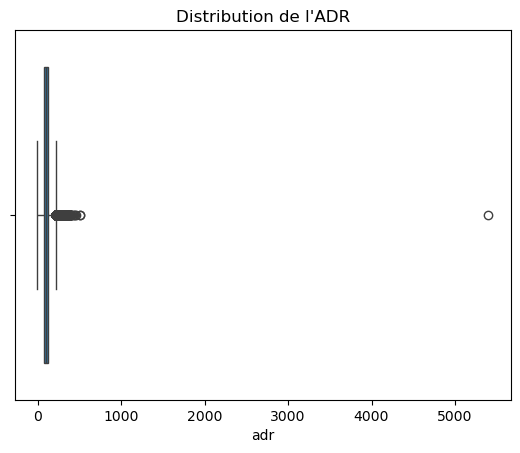

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x=df["adr"])
plt.title("Distribution de l'ADR")
plt.show()

In [11]:
df["adr"].describe()

count    119390.000000
mean        101.831122
std          50.535790
min          -6.380000
25%          69.290000
50%          94.575000
75%         126.000000
max        5400.000000
Name: adr, dtype: float64

Observation :
Présence de valeurs extrêmes supérieures à 1000€ et de valeurs négatives.

Décision :
Filtrage des ADR inférieurs à 0 et supérieurs au 99e percentile afin de conserver une distribution réaliste.

In [12]:
upper_limit = df["adr"].quantile(0.99)
df = df[(df["adr"] >= 0) & (df["adr"] <= upper_limit)]

## 3.3 Reconstruction d’une date complète

Les variables de date sont séparées.
Création d’une variable datetime exploitable pour l’analyse temporelle.

In [13]:
df["arrival_date"] = pd.to_datetime(
    df["arrival_date_year"].astype(str) + "-" +
    df["arrival_date_month"] + "-" +
    df["arrival_date_day_of_month"].astype(str)
)

In [14]:
df["arrival_date"] = pd.to_datetime(
    df["arrival_date_year"].astype(str) + " " +
    df["arrival_date_month"] + " " +
    df["arrival_date_day_of_month"].astype(str)
)

## 3.4 Feature Engineering

Objectif :
Créer de nouvelles variables pertinentes pour l’analyse Revenue Management.

Les variables créées permettront :
- d’estimer le revenu réel
- d’analyser la saisonnalité
- de segmenter le comportement de réservation
- d’identifier les profils à risque d’annulation

### 3.4.1 Création du revenu net

L’ADR représente le prix journalier moyen.
Cependant, une réservation annulée ne génère pas de revenu.

Nous créons donc une variable `revenue_net` :
ADR × (1 - is_canceled)

In [15]:
df["revenue_net"] = df["adr"] * (1 - df["is_canceled"])

df[["adr", "is_canceled", "revenue_net"]].head()

,adr,is_canceled,revenue_net
0,0.0,0,0.0
1,0.0,0,0.0
2,75.0,0,75.0
3,75.0,0,75.0
4,98.0,0,98.0


### 3.4.2 Extraction du mois et création de la saison

Afin d’analyser les variations de performance selon les périodes de l’année,
nous extrayons le mois et définissons une variable "season".

In [16]:
df["month"] = df["arrival_date"].dt.month

In [17]:
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df["season"] = df["month"].apply(get_season)

df[["arrival_date", "month", "season"]].head()

,arrival_date,month,season
0,2015-07-01,7,Summer
1,2015-07-01,7,Summer
2,2015-07-01,7,Summer
3,2015-07-01,7,Summer
4,2015-07-01,7,Summer


### 3.4.3 Séjour incluant un week-end

Les séjours incluant un week-end peuvent avoir un comportement tarifaire différent.

Nous créons une variable binaire :
True = au moins une nuit de week-end.

In [18]:
df["is_weekend_stay"] = df["stays_in_weekend_nights"] > 0

df["is_weekend_stay"].value_counts()

is_weekend_stay
True     66592
False    51629
Name: count, dtype: int64

### 3.4.4 Catégorisation du délai de réservation (Lead Time)

Le lead time représente le nombre de jours entre la réservation et l’arrivée.

Nous créons des catégories pour analyser le risque d’annulation selon l’anticipation.

In [19]:
df["lead_bucket"] = pd.cut(
    df["lead_time"],
    bins=[0, 7, 30, 90, 180, 500],
    labels=["0-6j", "7-29j", "30-89j", "90-179j", "180+j"]
)

df["lead_bucket"].value_counts()

lead_bucket
30-89j     29157
90-179j    26191
180+j      24123
7-29j      18665
0-6j       13287
Name: count, dtype: int64

### 3.4.5 Durée totale du séjour

La durée peut influencer :
- le prix
- le risque d’annulation
- le revenu global

In [20]:
df["total_nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]

df["total_nights"].describe()

count    118221.000000
mean          3.420357
std           2.557118
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          69.000000
Name: total_nights, dtype: float64

### 3.4.6 Taille totale du groupe

Nous combinons adultes, enfants et bébés
afin d’analyser les comportements selon la taille du groupe.

In [21]:
df["total_guests"] = df["adults"] + df["children"] + df["babies"]

df["total_guests"].describe()

count    118221.000000
mean          1.955642
std           0.708298
min           0.000000
25%           2.000000
50%           2.000000
75%           2.000000
max          55.000000
Name: total_guests, dtype: float64

### Conclusion – Feature Engineering

Les variables créées permettent :

- Une estimation plus réaliste du revenu généré.
- Une analyse saisonnière pertinente.
- Une segmentation comportementale du délai de réservation.
- Une meilleure compréhension du profil client.

Les données sont désormais prêtes pour l’analyse exploratoire (EDA).

# 4. Analyse exploratoire (EDA)

Objectif :
Identifier les facteurs influençant la performance revenue et le risque d’annulation afin de répondre à la problématique définie.

## 4.1 Comparaison City vs Resort

Objectif :
Comparer la performance des deux types d’hôtels afin d’identifier des différences structurelles.

In [22]:
city_resort = df.groupby("hotel").agg({
    "adr": "mean",
    "is_canceled": "mean",
    "revenue_net": "sum",
    "total_nights": "mean"
}).reset_index()

# Conversion en pourcentage pour plus de lisibilité
city_resort["is_canceled"] = city_resort["is_canceled"] * 100

city_resort

,hotel,adr,is_canceled,revenue_net,total_nights
0,City Hotel,104.575529,41.755558,4832698.88,2.977654
1,Resort Hotel,90.697675,27.554093,2470511.14,4.313049


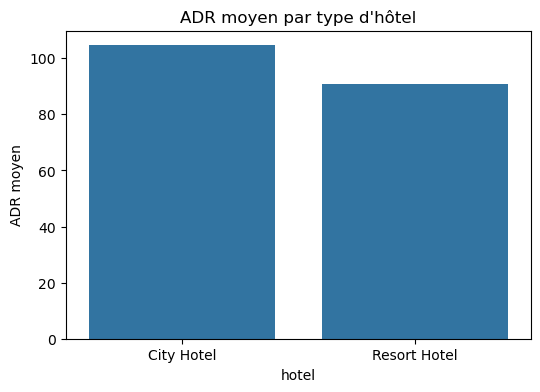

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.barplot(data=city_resort, x="hotel", y="adr")
plt.title("ADR moyen par type d'hôtel")
plt.ylabel("ADR moyen")
plt.show()

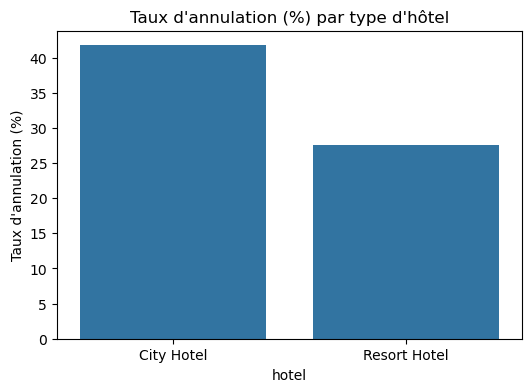

In [24]:
plt.figure(figsize=(6,4))
sns.barplot(data=city_resort, x="hotel", y="is_canceled")
plt.title("Taux d'annulation (%) par type d'hôtel")
plt.ylabel("Taux d'annulation (%)")
plt.show()

### Interprétation

- Le City Hotel présente un taux d’annulation plus élevé que le Resort Hotel.
- Le City Hotel affiche également un ADR moyen plus élevé (104,58 € contre 90,70 €).
- Le Resort Hotel se distingue par une durée moyenne de séjour plus longue (4,31 nuits contre 2,98 nuits).

Ces différences structurelles suggèrent que les stratégies revenue doivent être adaptées selon le type d’établissement.

### Implications business

Les deux types d’hôtels ne peuvent pas appliquer la même stratégie revenue.

- Le City Hotel doit prioritairement travailler sur la réduction du risque d’annulation.
- Le Resort Hotel peut davantage capitaliser sur l’optimisation tarifaire.

## 4.2 Analyse par segment de marché (Market Segment)

Objectif :
Identifier les segments clients les plus rentables et ceux présentant le plus fort risque d’annulation.

Cette analyse permet d’orienter les décisions de ciblage et d’ajustement tarifaire.

In [25]:
seg_market = df.groupby("market_segment").agg({
    "adr": "mean",
    "is_canceled": "mean",
    "revenue_net": "sum",
    "total_nights": "mean"
}).reset_index()

# Conversion en pourcentage
seg_market["is_canceled"] *= 100

# Tri par revenu net décroissant
seg_market = seg_market.sort_values("revenue_net", ascending=False)

seg_market

,market_segment,adr,is_canceled,revenue_net,total_nights
6,Online TA,114.893440,36.612512,3947980.72,3.565605
5,Offline TA/TO,86.933348,34.330826,1321209.18,3.903488
3,Direct,110.709288,15.163868,1138977.58,3.172672
4,Groups,79.147316,61.146497,586403.09,2.993580
2,Corporate,69.190788,18.707483,288246.53,2.093348
0,Aviation,100.142110,21.940928,18404.18,3.607595
1,Complementary,2.886366,13.055182,1988.74,1.647376
7,Undefined,15.000000,100.000000,0.00,1.500000


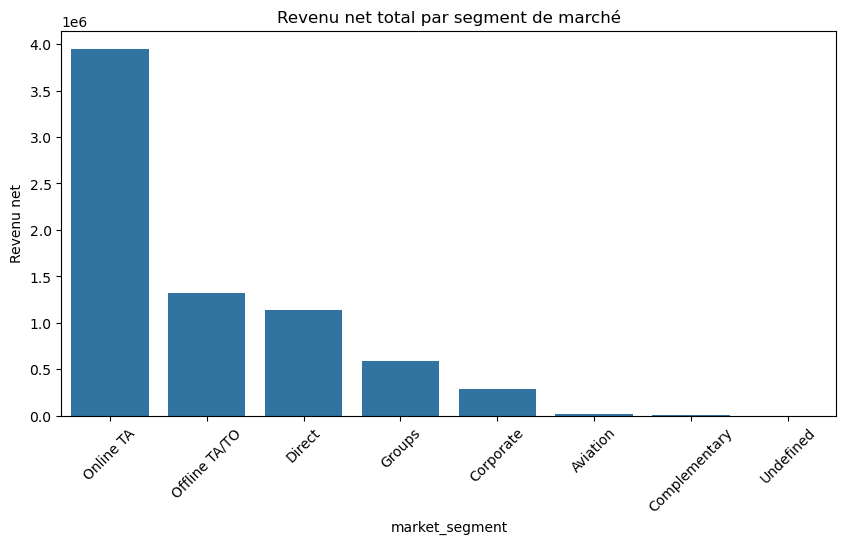

In [26]:
# Visualisation du revenu net par segment

plt.figure(figsize=(10,5))
sns.barplot(data=seg_market, x="market_segment", y="revenue_net")
plt.xticks(rotation=45)
plt.title("Revenu net total par segment de marché")
plt.ylabel("Revenu net")
plt.show()

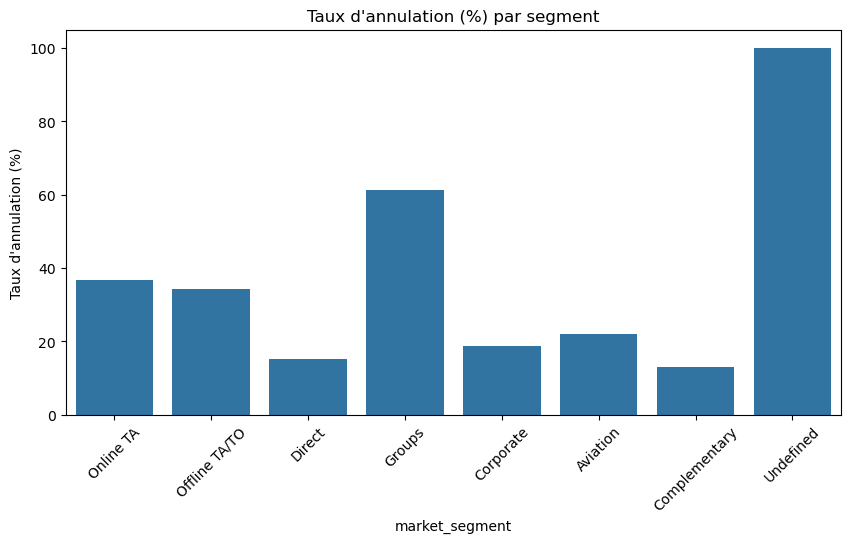

In [27]:
#Visualisation du taux d'annulation

plt.figure(figsize=(10,5))
sns.barplot(data=seg_market, x="market_segment", y="is_canceled")
plt.xticks(rotation=45)
plt.title("Taux d'annulation (%) par segment")
plt.ylabel("Taux d'annulation (%)")
plt.show()

### Interprétation

- Certains segments génèrent un volume de revenu important mais présentent un taux d’annulation élevé.
- D’autres segments, bien que moins volumineux, sont plus stables et présentent un risque plus faible.
- Les segments corporate / direct semblent plus sécurisés que certains segments OTA.

### Implications business

- Les segments à fort revenu mais fort taux d’annulation nécessitent une politique de dépôt ou une stratégie d’overbooking maîtrisée.
- Les segments stables peuvent faire l’objet d’une stratégie de fidélisation.
- Une priorisation des segments les plus rentables et les plus fiables est recommandée.

## 4.3 Analyse par canal de distribution (Distribution Channel)

Objectif :
Analyser la performance des différents canaux de distribution afin d’identifier :
- Les canaux les plus générateurs de revenu
- Les canaux les plus risqués en termes d’annulation
- Les implications stratégiques en matière de dépendance aux OTA

In [28]:
#Calcul des indicateurs par canal

seg_channel = df.groupby("distribution_channel").agg({
    "adr": "mean",
    "is_canceled": "mean",
    "revenue_net": "sum",
    "total_nights": "mean"
}).reset_index()

seg_channel["is_canceled"] *= 100

seg_channel = seg_channel.sort_values("revenue_net", ascending=False)

seg_channel

,distribution_channel,adr,is_canceled,revenue_net,total_nights
3,TA/TO,101.752285,41.004430,5737044.92,3.531678
1,Direct,102.020019,17.382170,1197959.53,3.169059
0,Corporate,69.191847,22.055739,349383.25,2.381181
2,GDS,120.554301,19.170984,18709.62,1.958549
4,Undefined,46.240000,80.000000,112.70,3.400000


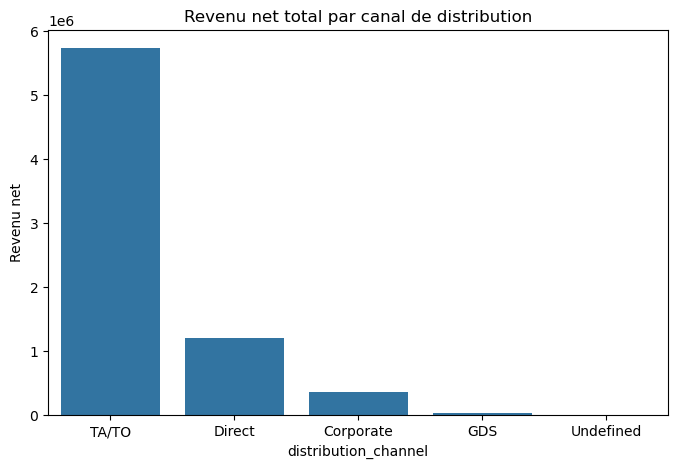

In [29]:
#Visualisation du revenu net par canal

plt.figure(figsize=(8,5))
sns.barplot(data=seg_channel, x="distribution_channel", y="revenue_net")
plt.title("Revenu net total par canal de distribution")
plt.ylabel("Revenu net")
plt.show()

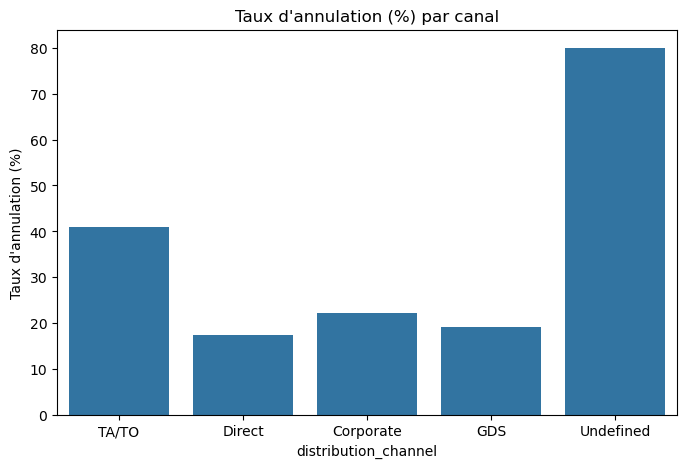

In [30]:
#Visualisation du taux d’annulation

plt.figure(figsize=(8,5))
sns.barplot(data=seg_channel, x="distribution_channel", y="is_canceled")
plt.title("Taux d'annulation (%) par canal")
plt.ylabel("Taux d'annulation (%)")
plt.show()

### Interprétation

- Les canaux OTA génèrent un volume important de réservations.
- Cependant, ils présentent un taux d’annulation plus élevé que les canaux directs.
- Les réservations directes semblent plus stables et plus prévisibles.

### Implications business

- Une dépendance excessive aux OTA peut augmenter le risque de volatilité du revenu.
- Encourager les réservations directes (site web, fidélisation) peut réduire le risque d’annulation.
- Une politique de dépôt différenciée selon le canal peut être envisagée.

## 4.4 Analyse par saison

Objectif :
Identifier les variations de performance selon les périodes de l’année afin d’adapter la stratégie tarifaire et la gestion du risque d’annulation.

In [31]:
#Calcul des indicateurs par saison

season_analysis = df.groupby("season").agg({
    "adr": "mean",
    "is_canceled": "mean",
    "revenue_net": "sum",
    "total_nights": "mean"
}).reset_index()

season_analysis["is_canceled"] *= 100

season_analysis

,season,adr,is_canceled,revenue_net,total_nights
0,Autumn,90.696206,36.830075,1611261.74,3.266915
1,Spring,96.727409,37.772523,1886021.77,3.350335
2,Summer,124.593163,38.800614,2807246.40,3.795984
3,Winter,74.439397,33.117729,998680.11,3.079210


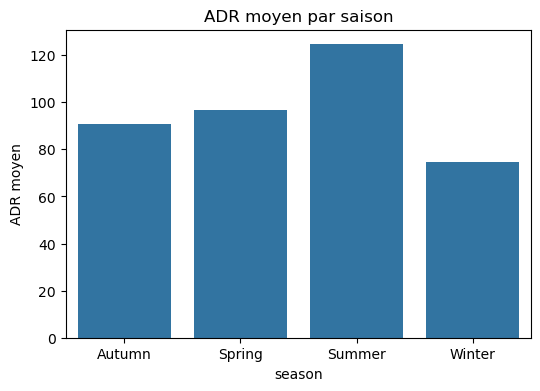

In [32]:
#Visualisation ADR moyen

plt.figure(figsize=(6,4))
sns.barplot(data=season_analysis, x="season", y="adr")
plt.title("ADR moyen par saison")
plt.ylabel("ADR moyen")
plt.show()

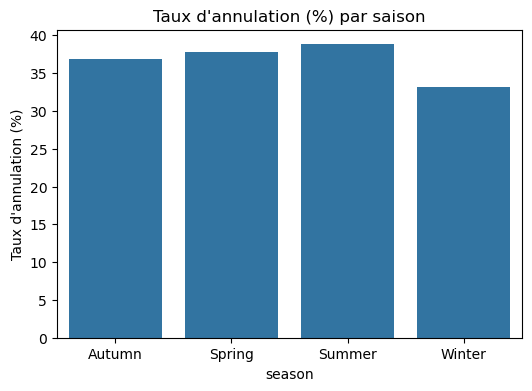

In [33]:
#Visualisation taux d'annulation

plt.figure(figsize=(6,4))
sns.barplot(data=season_analysis, x="season", y="is_canceled")
plt.title("Taux d'annulation (%) par saison")
plt.ylabel("Taux d'annulation (%)")
plt.show()

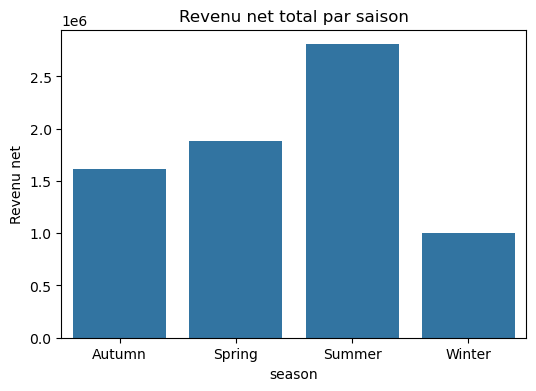

In [34]:
#Visualisation du revenu total

plt.figure(figsize=(6,4))
sns.barplot(data=season_analysis, x="season", y="revenue_net")
plt.title("Revenu net total par saison")
plt.ylabel("Revenu net")
plt.show()

### Interprétation

- L’ADR est plus élevé en saison haute (été).
- Le revenu net est concentré sur certaines saisons.
- Le taux d’annulation peut varier selon la période.

### Implications business

- En haute saison, l’optimisation tarifaire est prioritaire.
- En basse saison, des stratégies promotionnelles peuvent être envisagées.
- Une politique de dépôt renforcée peut être mise en place durant les périodes à fort risque d’annulation.

## 4.5 Analyse selon le délai de réservation (Lead Time)

Objectif :
Analyser l’impact du délai entre la réservation et la date d’arrivée sur :
- le taux d’annulation
- l’ADR
- le revenu net

Cette analyse permet d’identifier les profils de réservation à risque.

In [35]:
#Indicateurs par tranche de lead time

lead_analysis = df.groupby("lead_bucket").agg({
    "adr": "mean",
    "is_canceled": "mean",
    "revenue_net": "sum",
    "total_nights": "mean"
}).reset_index()

lead_analysis["is_canceled"] *= 100

lead_analysis

C:\Users\solen\AppData\Local\Temp\ipykernel_15848\1857592719.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lead_analysis = df.groupby("lead_bucket").agg({


,lead_bucket,adr,is_canceled,revenue_net,total_nights
0,0-6j,91.524404,10.988184,1073761.51,2.205088
1,7-29j,105.323554,27.773908,1374327.46,3.081543
2,30-89j,103.942094,37.716500,1840055.62,3.557671
3,90-179j,107.462968,44.679470,1514963.01,4.081173
4,180+j,92.820885,56.452348,1010548.35,3.975169


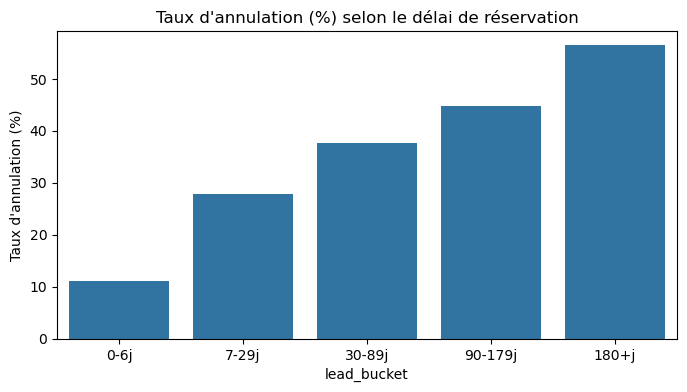

In [36]:
# Visualisation du taux d’annulation

plt.figure(figsize=(8,4))
sns.barplot(data=lead_analysis, x="lead_bucket", y="is_canceled")
plt.title("Taux d'annulation (%) selon le délai de réservation")
plt.ylabel("Taux d'annulation (%)")
plt.show()

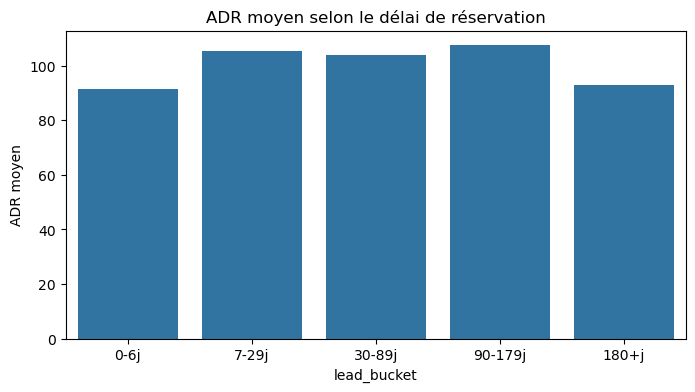

In [37]:
# Visualisation de l’ADR

plt.figure(figsize=(8,4))
sns.barplot(data=lead_analysis, x="lead_bucket", y="adr")
plt.title("ADR moyen selon le délai de réservation")
plt.ylabel("ADR moyen")
plt.show()

### Interprétation

- Les réservations effectuées très en amont présentent un taux d’annulation plus élevé.
- Les réservations de dernière minute semblent plus stables.
- L’ADR peut varier selon l’anticipation de réservation.

### Implications business

- Les réservations avec un long lead time peuvent nécessiter une politique de dépôt.
- Une stratégie d’overbooking peut être envisagée pour compenser les annulations anticipées.
- Une segmentation tarifaire selon l’anticipation peut être pertinente.

# 5. Recommandations stratégiques

Objectif :
Formuler des recommandations concrètes basées sur les analyses précédentes afin d’optimiser le revenu net et réduire le risque d’annulation.

## 5.1 Réduction du risque d’annulation

Les analyses montrent que :
- Les réservations effectuées très en amont présentent un taux d’annulation élevé.
- Certains segments et canaux présentent un risque plus important.

Recommandations :
- Mettre en place une politique de dépôt obligatoire pour les réservations avec long lead time.
- Adapter les conditions d’annulation selon le segment client.
- Mettre en place une stratégie d’overbooking maîtrisée pour compenser les annulations anticipées.

## 5.2 Optimisation de la stratégie tarifaire

Les analyses saisonnières montrent :
- Un ADR plus élevé en haute saison.
- Une concentration du revenu sur certaines périodes.

Recommandations :
- Augmenter progressivement les tarifs en haute saison.
- Mettre en place des offres promotionnelles en basse saison.
- Adapter les prix selon la durée de séjour.

## 5.3 Optimisation du mix canal

Les canaux OTA génèrent du volume mais présentent un risque d’annulation plus élevé.

Recommandations :
- Encourager les réservations directes via des avantages fidélité.
- Réduire la dépendance excessive aux OTA.
- Différencier les conditions tarifaires selon le canal.

## 5.4 Priorisation des segments

Les segments les plus stables et rentables doivent être priorisés.

Recommandations :
- Développer des offres spécifiques pour les segments corporate.
- Identifier les segments à faible marge et fort risque pour ajustement.

## Conclusion générale

L’analyse a permis d’identifier les principaux facteurs influençant le revenu net et le risque d’annulation.

Une stratégie combinant :
- Ajustement tarifaire
- Gestion du risque d’annulation
- Optimisation du mix canal

permettrait d’améliorer significativement la performance revenue de l’établissement.

## Export du dataset nettoyé

Afin de faciliter la création du dashboard Power BI,
le dataset nettoyé est exporté au format CSV.

In [38]:
df.to_csv("hotel_bookings_cleaned.csv", index=False)